In [1]:
import pandas as pd

Cargo un archivo csv, creado a partir de los accesos al servidor de apache de SEDICI, correspondientes a un día entero. 

In [2]:
df = pd.read_parquet('data/df_log.parquet.gzip')
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype                    
---  ------      --------------  -----                    
 0   ip          50000 non-null  string                   
 1   time        50000 non-null  datetime64[ns, UTC-03:00]
 2   request     50000 non-null  string                   
 3   status      50000 non-null  Int64                    
 4   size        50000 non-null  Int64                    
 5   Referer     8759 non-null   string                   
 6   User_agent  49949 non-null  string                   
 7   spambot     50000 non-null  boolean                  
dtypes: Int64(2), boolean(1), datetime64[ns, UTC-03:00](1), string(4)
memory usage: 2.9 MB


Reemplazo valores nulos en User_agent con el texto 'NOTSET'

In [3]:
df['User_agent'] = df['User_agent'].fillna(value='NULL')
df['Referer'] = df['Referer'].fillna(value='NULL')

In [4]:
df.head(5)

,ip,time,request,status,size,Referer,User_agent,spambot
0,3.224.220.101,2022-03-31 00:00:13-03:00,GET /handle/10915/60216/browse?authority=http%...,200,7165,NULL,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,True
1,173.252.107.9,2022-03-31 00:00:13-03:00,GET /handle/10915/45833 HTTP/1.1,200,9539,NULL,facebookexternalhit/1.1 (+http://www.facebook....,False
2,173.252.107.3,2022-03-31 00:00:13-03:00,GET /handle/10915/31292 HTTP/1.1,200,9512,NULL,facebookexternalhit/1.1 (+http://www.facebook....,False
3,173.252.107.22,2022-03-31 00:00:14-03:00,GET /handle/10915/66507 HTTP/1.1,200,10170,NULL,facebookexternalhit/1.1 (+http://www.facebook....,False
4,173.252.107.9,2022-03-31 00:00:14-03:00,GET /handle/10915/66507 HTTP/1.1,200,10170,NULL,facebookexternalhit/1.1 (+http://www.facebook....,False


La idea es aplicar K-Means a partir de la cantidad de requests que hace una IP junto con el tamaño en bytes descargado en un día. Para se va a agrupar cada acceso del log por IP y se agregar una columna para la cantidad de requests en un día junto con la cantidad de bytes descargados

In [5]:
df_groupby_ip = df.groupby('ip', as_index=False).size().rename(columns={'size':'count'}) # agrupo por ip y agrego un columna count con la cantidad de requests hechas 
df_groupby_ip['size'] = df.groupby('ip', as_index=False)['size'].sum()['size'] # agrego a df_groupby_ip una columna con la cantidad de bytes descargados en un día
df_groupby_ip

,ip,count,size
0,1.47.151.27,2,1630020
1,100.24.12.213,1,11140
2,101.80.68.12,1,8422
3,102.129.153.243,1,8422
4,102.165.48.50,1,17722
...,...,...,...
5652,95.62.55.197,1,832416
5653,95.74.48.78,3,22080
5654,98.126.219.75,2,1184056
5655,98.167.168.137,1,112350


In [6]:
df_groupby_ip = pd.merge(df[['ip', 'spambot']], df_groupby_ip, how='inner', on=['ip']) 
df_groupby_ip

,ip,spambot,count,size
0,3.224.220.101,True,4045,38194228
1,3.224.220.101,True,4045,38194228
2,3.224.220.101,True,4045,38194228
3,3.224.220.101,True,4045,38194228
4,3.224.220.101,True,4045,38194228
...,...,...,...,...
49995,150.214.205.80,False,1,225515
49996,18.234.77.104,False,1,6037
49997,79.169.50.192,False,1,1886670
49998,62.83.221.26,False,2,13422


Escalo datos para poder procesarlos con KMeans

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler().fit(df_groupby_ip[['count','size','spambot']].values)

In [9]:
df_cluster = pd.DataFrame(scaler.transform(df_groupby_ip[['count','size','spambot']].values),
                       columns=["cantidad", "tamaño",'spambot'])

In [10]:
df_cluster

,cantidad,tamaño,spambot
0,0.425416,0.018548,1.0
1,0.425416,0.018548,1.0
2,0.425416,0.018548,1.0
3,0.425416,0.018548,1.0
4,0.425416,0.018548,1.0
...,...,...,...
49995,0.000000,0.000109,0.0
49996,0.000000,0.000003,0.0
49997,0.000000,0.000916,0.0
49998,0.000105,0.000006,0.0


## KMeans

In [11]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

In [12]:
db_indexes = {}
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters).fit(df_cluster.values)
    db_index = davies_bouldin_score(df_cluster.values, kmeans.labels_)
    db_indexes.update({n_clusters: db_index})

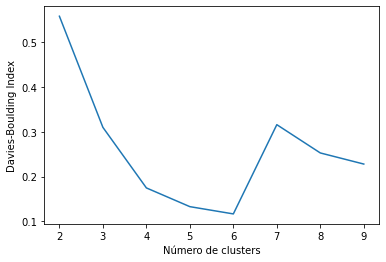

In [13]:
plt.plot(list(db_indexes.keys()), list(db_indexes.values()))
plt.xlabel("Número de clusters")
plt.ylabel("Davies-Boulding Index")
plt.show()

Nos quedamos con 3 como la cantidad de clusters a usar debido a que su índice de David Boulding es el menor

In [14]:
n_clusters = 6
kmeans = KMeans(n_clusters).fit(df_cluster.values)
df_cluster["cluster"] = kmeans.labels_
df_groupby_ip ["cluster"] = df_cluster["cluster"]
df_groupby_ip


,ip,spambot,count,size,cluster
0,3.224.220.101,True,4045,38194228,1
1,3.224.220.101,True,4045,38194228,1
2,3.224.220.101,True,4045,38194228,1
3,3.224.220.101,True,4045,38194228,1
4,3.224.220.101,True,4045,38194228,1
...,...,...,...,...,...
49995,150.214.205.80,False,1,225515,0
49996,18.234.77.104,False,1,6037,0
49997,79.169.50.192,False,1,1886670,0
49998,62.83.221.26,False,2,13422,0


Dibujo

In [15]:
from random import randint
colores = []
for i in range(n_clusters):
    colores.append('#%06X' % randint(0, 0xFFFFFF))

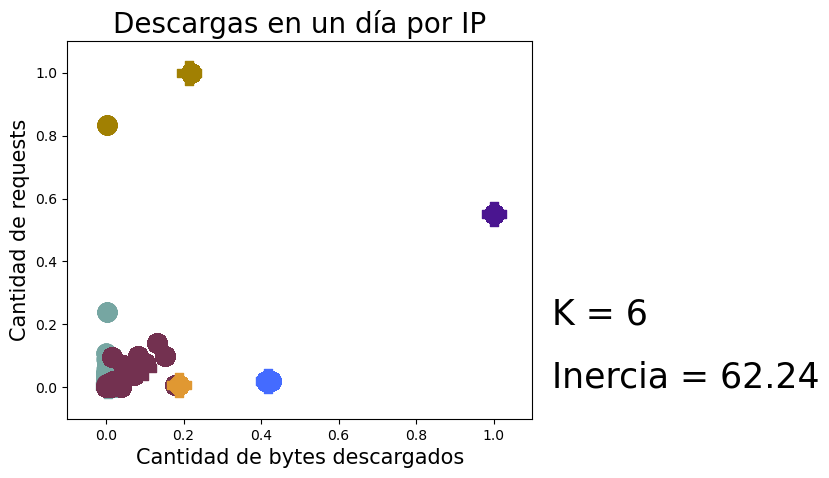

In [16]:
plt.figure(figsize=(6, 5), dpi=100)

#colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]
for cluster in range(kmeans.n_clusters):
    plt.scatter(df_cluster[df_cluster["cluster"] == cluster]["cantidad"],
                df_cluster[df_cluster["cluster"] == cluster]["tamaño"],
                marker="o", s=180, color=colores[cluster], alpha=0.5)
    
    plt.scatter(kmeans.cluster_centers_[cluster][0], 
                kmeans.cluster_centers_[cluster][1], 
                marker="P", s=280, color=colores[cluster])

plt.title("Descargas en un día por IP", fontsize=20)
plt.xlabel("Cantidad de bytes descargados", fontsize=15)
plt.ylabel("Cantidad de requests", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=25)
plt.text(1.15, 0, "Inercia = %0.2f" % kmeans.inertia_, fontsize=25)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)    
plt.show()

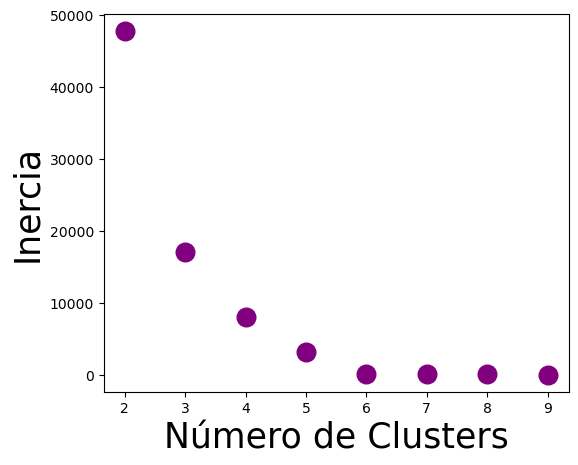

In [17]:
inercias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(df_cluster.values)
    inercias.append(kmeans.inertia_)

plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(range(2, 10), inercias, marker="o", s=180, color="purple")
plt.xlabel("Número de Clusters", fontsize=25)
plt.ylabel("Inercia", fontsize=25)
plt.show()

In [18]:
pd.merge(df, df_groupby_ip[['ip', 'cluster']], on=['ip'])


,ip,time,request,status,size,Referer,User_agent,spambot,cluster
0,3.224.220.101,2022-03-31 00:00:13-03:00,GET /handle/10915/60216/browse?authority=http%...,200,7165,NULL,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,True,1
1,3.224.220.101,2022-03-31 00:00:13-03:00,GET /handle/10915/60216/browse?authority=http%...,200,7165,NULL,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,True,1
2,3.224.220.101,2022-03-31 00:00:13-03:00,GET /handle/10915/60216/browse?authority=http%...,200,7165,NULL,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,True,1
3,3.224.220.101,2022-03-31 00:00:13-03:00,GET /handle/10915/60216/browse?authority=http%...,200,7165,NULL,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,True,1
4,3.224.220.101,2022-03-31 00:00:13-03:00,GET /handle/10915/60216/browse?authority=http%...,200,7165,NULL,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,True,1
...,...,...,...,...,...,...,...,...,...
155578893,79.169.50.192,2022-03-31 04:58:02-03:00,GET /bitstream/handle/10915/35114/Documento_co...,200,1886670,https://www.google.com/,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,False,0
155578894,62.83.221.26,2022-03-31 04:58:13-03:00,GET /handle/10915/131096 HTTP/1.1,200,8896,https://l.instagram.com/,Mozilla/5.0 (iPhone; CPU iPhone OS 15_3_1 like...,False,0
155578895,62.83.221.26,2022-03-31 04:58:13-03:00,GET /handle/10915/131096 HTTP/1.1,200,8896,https://l.instagram.com/,Mozilla/5.0 (iPhone; CPU iPhone OS 15_3_1 like...,False,0
155578896,62.83.221.26,2022-03-31 04:58:15-03:00,GET /bitstream/handle/10915/131096/universidad...,200,4526,http://sedici.unlp.edu.ar/handle/10915/131096,Mozilla/5.0 (iPhone; CPU iPhone OS 15_3_1 like...,False,0


In [20]:
df_spambot = df_groupby_ip[df_groupby_ip['spambot'] == True]

In [101]:
df_groupby_ip[(df_groupby_ip['cluster'] == 0) & (df_groupby_ip['spambot'] == True) ]

,ip,spambot,count,size,cluster


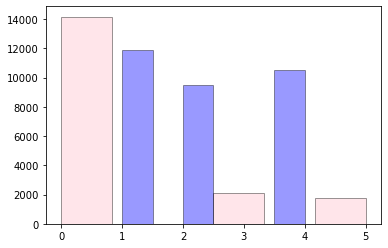

In [94]:
plt.hist(df_groupby_ip['cluster'][~(df_groupby_ip['spambot'])], color="pink", ec="black", bins=6, alpha=0.4)
plt.hist(df_groupby_ip['cluster'][df_groupby_ip['spambot']], color="blue", ec="black", bins=6, alpha=0.4)
plt.show()


In [87]:
df_cluster.head(1)

,cantidad,tamaño,spambot,cluster
0,0.425416,0.018548,1.0,1


A continuación se utilizará la técnica de Arbol de clasificación para explicar que criterios se usaron para el clustering

In [102]:
from sklearn.model_selection import train_test_split

datos_entrena, datos_prueba, clase_entrena, clase_prueba = train_test_split(
    df_groupby_ip[["count", "size", "spambot"]],
    df_groupby_ip["cluster"], 
    test_size=0.30)


1.0
|--- cantidad <= 1732.50
|   |--- spambot <= 0.50
|   |   |--- tamaño <= 1104995296.00
|   |   |   |--- class: 0
|   |   |--- tamaño >  1104995296.00
|   |   |   |--- class: 3
|   |--- spambot >  0.50
|   |   |--- class: 4
|--- cantidad >  1732.50
|   |--- tamaño <= 586105396.00
|   |   |--- spambot <= 0.50
|   |   |   |--- class: 5
|   |   |--- spambot >  0.50
|   |   |   |--- class: 1
|   |--- tamaño >  586105396.00
|   |   |--- tamaño <= 1595713024.00
|   |   |   |--- class: 2
|   |   |--- tamaño >  1595713024.00
|   |   |   |--- class: 3



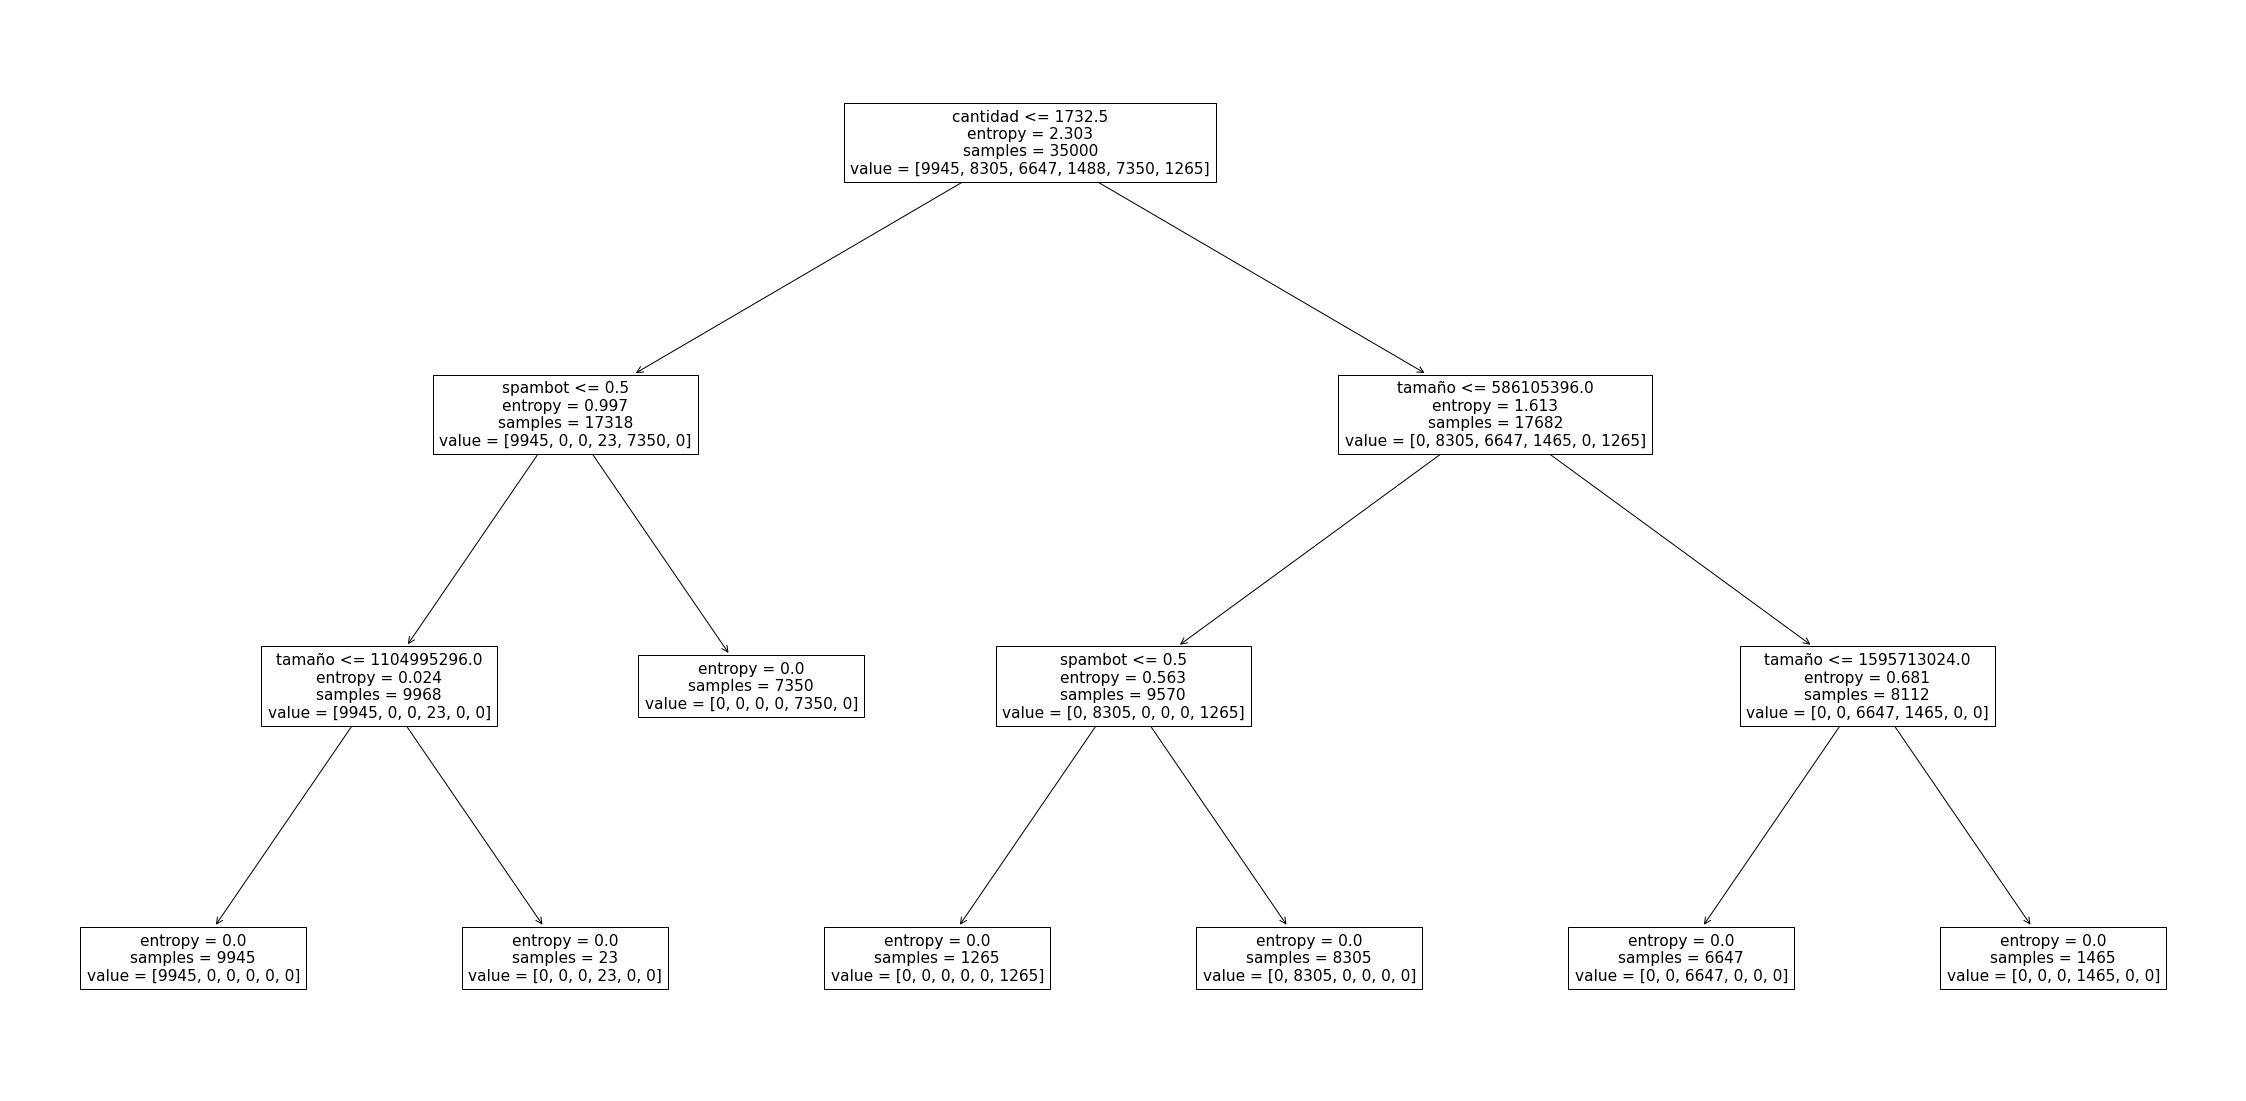

In [103]:
from sklearn import tree

arbol_decision = tree.DecisionTreeClassifier(criterion="entropy")

arbol = arbol_decision.fit(datos_entrena, clase_entrena)

accuracy = arbol_decision.score(datos_prueba, clase_prueba)

print(accuracy)

print(tree.export_text(arbol, feature_names=["cantidad", "tamaño", "spambot"]))
plt.figure(figsize=(40, 20))
tree.plot_tree(arbol, feature_names=["cantidad", "tamaño", "spambot"])
plt.show()

